# Thorium Calibration

We simulate a thorium mantle attached next to the tank. We calculate the expected spectrum for the energy deposition as well as the rate of incidence.

In [1]:
#Include modules
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from accelerate import parallel, concat
from tqdm.notebook import tqdm

%matplotlib widget

In [15]:
# Read the files

# Parameters
run                     = 'run3'
header                  = ['EventID','TrackID','Particle','EnergyDeposited','XPosition','YPosition','ZPosition','LocalTime','Volume', 'Initial Energy', 'Origin Volume', 'MigrantID']

# Find the files
foldername  = f'../build/output'
os.system(f'rm -rf ../build/output/.ipynb_checkpoints')
filenames   = os.listdir(foldername)

print(f'Found {len(filenames)} data files in {foldername}')

def loadFile(filename):
    return pd.read_csv(os.path.join(foldername,filename),skiprows=16,names=header)

loadFiles = parallel(loadFile)

if __name__ == '__main__':
    files = loadFiles(filenames)

Found 1024 data files in ../build/output


  0%|          | 0/1024 [00:00<?, ?it/s]

In [16]:
# Function to extract the energy deposited per track
def getEnergy(data):
    return data.groupby(['EventID','TrackID','Particle'])[['EnergyDeposited', 'Initial Energy']].sum().reset_index()

getEnergies = concat(parallel(getEnergy))

# Get the incoming energy of the particles

# Get the deposited energies
energy = getEnergies(files)

# Split into the energy per particle
particleEnergies = {particle:energy.loc[energy.Particle == particle] for particle in energy.Particle.unique()}

  0%|          | 0/1024 [00:00<?, ?it/s]

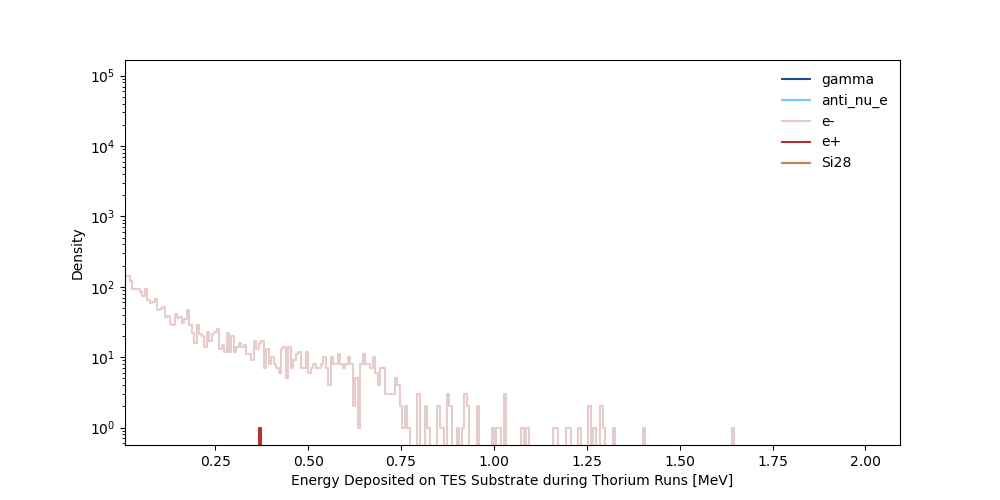

In [17]:
# Plot a histogram
fig = plt.figure(figsize=(10,5))
ax  = fig.add_subplot(111)

NBINS       = 300
LIMS        = (0,2)
BINS        = np.linspace(*LIMS,NBINS+1)
stackedHist = np.array([np.histogram(particleEnergies[particle].EnergyDeposited,bins=BINS)[0] for particle in particleEnergies])
color       = np.round(np.random.rand(len(stackedHist),3),1)
[ax.step(BINS[:-1],hist,label=particle,color=c) for hist,particle,c in zip(stackedHist,particleEnergies,color)]

ax.set_xlim(BINS[1],None)
# ax.set_ylim(0,np.max(,axis=0))
ax.set_xlabel('Energy Deposited on TES Substrate during Thorium Runs [MeV]')
ax.set_ylabel('Density')
ax.legend(frameon=False)
ax.set_yscale('log')
# ax.set_xscale('log')

In [18]:
len(particleEnergies['gamma'].EnergyDeposited) /len(energy)

0.28241406639856753

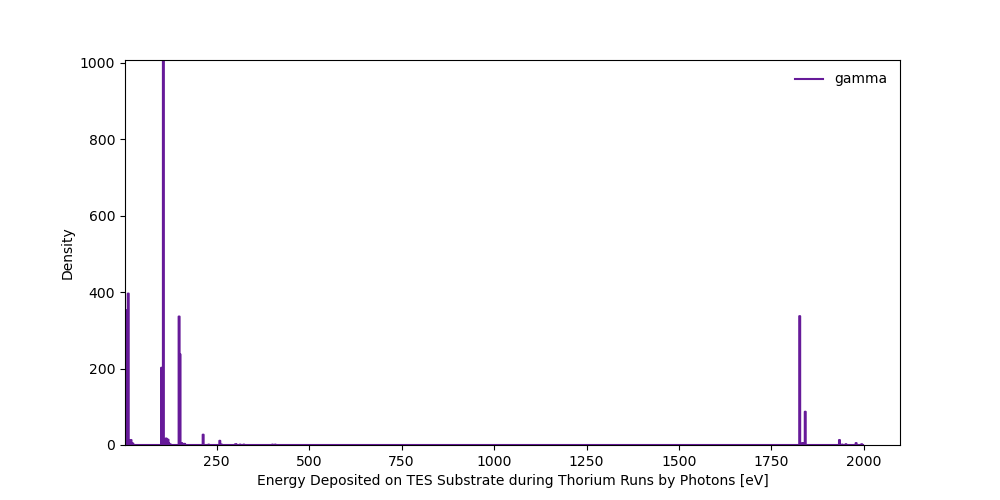

In [19]:
# Plot a histogram
fig = plt.figure(figsize=(10,5))
ax  = fig.add_subplot(111)

NBINS       = 800
LIMS        = (0,0.002)
BINS        = np.linspace(*LIMS,NBINS+1)
PARTICLE    = 'gamma'
stackedHist = np.histogram(particleEnergies[PARTICLE].EnergyDeposited,bins=BINS)[0]
color       = np.round(np.random.rand(len(stackedHist),3),1)
ax.step(BINS[:-1]*1e6,stackedHist,label=PARTICLE,color=color[0])

ax.set_xlim(BINS[1]*1e6,None)
ax.set_ylim(0,np.max(stackedHist[1:]))
ax.set_xlabel('Energy Deposited on TES Substrate during Thorium Runs by Photons [eV]')
ax.set_ylabel('Density')
ax.legend(frameon=False)
# ax.set_yscale('log')
# ax.set_xscale('log')

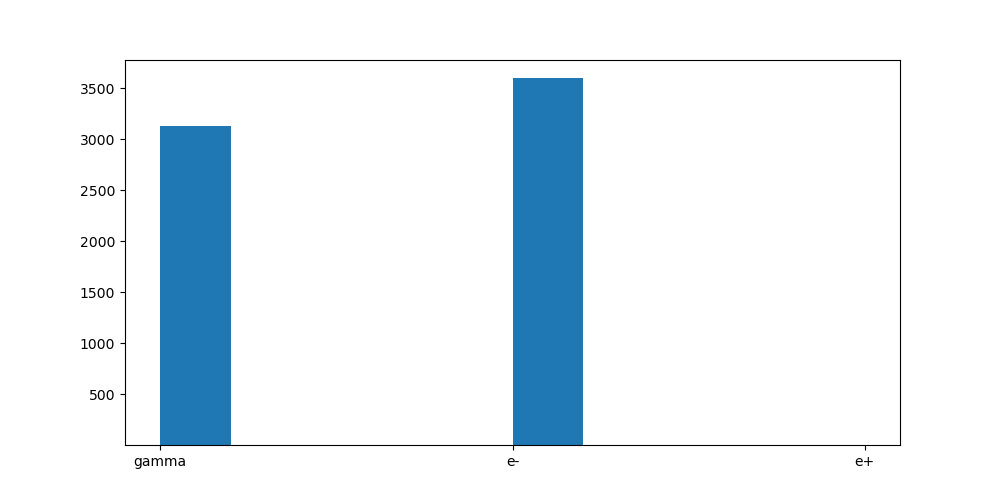

In [8]:
nonZeroEnergy = energy[energy['EnergyDeposited'] != 0]
data = nonZeroEnergy['Particle']
# data = energy['Particle']
plt.clf()
counts, bins, whatever = plt.hist(data)
# plt.yscale('log')
plt.ylim(0.1,)
plt.show()
#this is particles that have deposited energy on the tes

In [9]:
counts

array([3.127e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 3.595e+03,
       0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00])

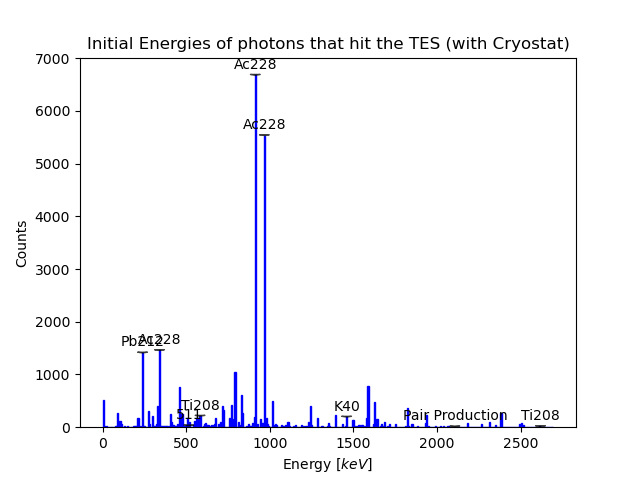

In [10]:
def annotate_peaks(ax, x_values, y_values, labels):
    for x, y, label in zip(x_values, y_values, labels):
        ax.annotate(label, xy=(x, y), xytext=(x, y + 200),  # Adjust xytext to control the label position
                    arrowprops=dict(facecolor='black', arrowstyle='wedge,tail_width=0.7', alpha=0.7),
                    horizontalalignment='center', verticalalignment='center')



x_irl = [238.6, 338.3, 511, 583.2, 911.2, 968.9, 1460, 2103, 2614.5]
material_names = ['Pb212', 'Ac228', '511', 'Ti208', 'Ac228', 'Ac228', 'K40', 'Pair Production', 'Ti208']
gamma = energy[energy['Particle'] == 'gamma']
gamma = gamma[gamma['Initial Energy'] < 2700]

plt.clf()
fig, ax = plt.subplots()
counts, bin_edges, patches = ax.hist(gamma['Initial Energy'], bins = 400, color = 'b', edgecolor = 'blue')
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

x_sim = []

for x in x_irl:
    try:
        x_sim.append(max([i for i in bin_centers if abs(x-i) < 5.]))
    except:
        pass
    
y_sim = []
for x,y in zip(bin_centers, counts):
    if x in x_sim:
        y_sim.append(y)




# plt.xscale('log')
# plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(base=100))
# ax.set_xlim(1,2700)
ax.set_xlabel('Energy [$keV$]')
ax.set_ylabel('Counts')
ax.set_yscale('linear')
ax.set_title('Initial Energies of photons that hit the TES (with Cryostat)')
annotate_peaks(ax, x_sim, y_sim, material_names)
plt.show()

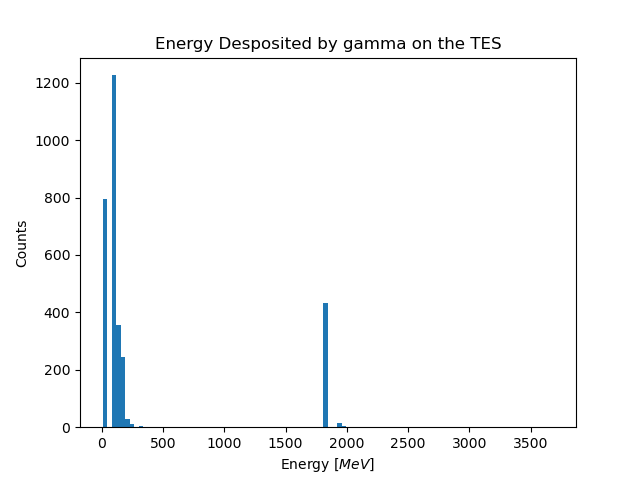

In [11]:
gamma = energy[energy['Particle'] == 'gamma']
gamma = gamma[gamma['EnergyDeposited'] > 0]
gamma = gamma['EnergyDeposited'] * 10**6
plt.clf()
plt.hist(gamma, bins = 100)
plt.title('Energy Desposited by gamma on the TES')
plt.xlabel('Energy [$MeV$]')
plt.ylabel('Counts')
# plt.xlim(0,100000)
plt.show()

In [12]:
len(gamma)

3127

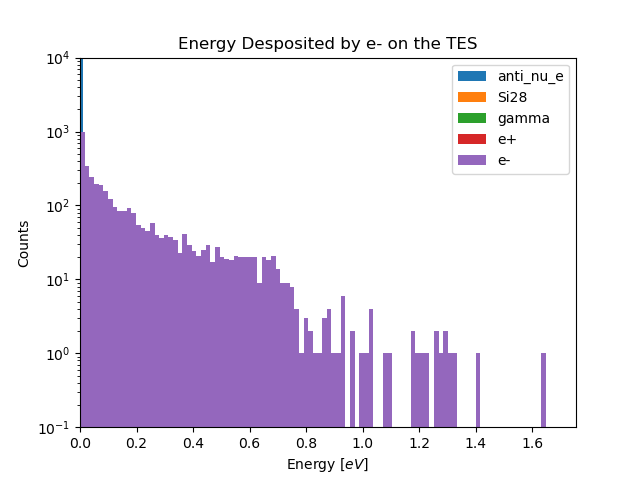

In [13]:
plt.clf()
particles = set(energy['Particle'])

for particle in particles:
    df = energy[energy['Particle'] == particle]
    # df = df[df['EnergyDeposited'] > 0]
    data = df['EnergyDeposited']
    plt.hist(data, bins = 100, label = particle)
plt.title('Energy Desposited by ' + particle + ' on the TES')
plt.xlabel('Energy [$eV$]')
plt.ylabel('Counts')
plt.xlim(0,)
plt.ylim(0.1,10000)
plt.xscale('linear')
plt.yscale('log')
plt.legend()
plt.show()

In [22]:
data = pd.concat(files)

In [26]:
data

,EventID,TrackID,Particle,EnergyDeposited,XPosition,YPosition,ZPosition,LocalTime,Volume,Initial Energy,Origin Volume,MigrantID
0,2641,17,gamma,0.0,-47.5000,-370.028,-11.60070,0.912777,physSiliconSubstrate,911.209,physicalThorium,-1
1,5395,38,anti_nu_e,0.0,-47.5000,-366.651,-9.91343,0.877267,physSiliconSubstrate,165.612,physicalThorium,-1
2,5529,14,anti_nu_e,0.0,-44.9252,-371.000,-8.69687,0.896077,physSiliconSubstrate,345.994,physicalThorium,-1
3,10534,11,anti_nu_e,0.0,-43.3841,-371.000,-9.01464,0.859846,physSiliconSubstrate,529.593,physicalThorium,-1
4,12358,33,anti_nu_e,0.0,-47.5000,-367.186,-10.20080,0.898370,physSiliconSubstrate,328.211,physicalThorium,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
200,949333,17,gamma,0.0,-47.5000,-370.576,-12.20460,0.904553,physSiliconSubstrate,911.209,physicalThorium,-1
201,956460,14,anti_nu_e,0.0,-47.5000,-366.864,-8.36061,0.894002,physSiliconSubstrate,883.607,physicalThorium,-1
202,958208,34,anti_nu_e,0.0,-42.8963,-371.000,-8.41949,0.857504,physSiliconSubstrate,723.068,physicalThorium,-1
203,973979,44,anti_nu_e,0.0,-47.5000,-369.040,-8.43910,0.895695,physSiliconSubstrate,1892.310,physicalThorium,-1


In [69]:
data = data.groupby(['EventID','TrackID','Particle', 'Origin Volume', 'MigrantID'])['EnergyDeposited'].sum().reset_index()
data

,EventID,TrackID,Particle,Origin Volume,MigrantID,EnergyDeposited
0,0,14,anti_nu_e,physicalThorium,-1,0.0
1,12,34,anti_nu_e,physicalThorium,-1,0.0
2,35,17,gamma,physicalThorium,-1,0.0
3,41,30,anti_nu_e,physicalThorium,-1,0.0
4,51,39,anti_nu_e,physicalThorium,-1,0.0
...,...,...,...,...,...,...
135130,976525,20,gamma,physicalThorium,-1,0.0
135131,976529,36,anti_nu_e,physicalThorium,-1,0.0
135132,976532,34,gamma,physicalThorium,-1,0.0
135133,976555,35,anti_nu_e,physicalThorium,-1,0.0


In [112]:
gamma = data[data['Particle'] == 'gamma']
gamma = gamma.drop(columns = ['Particle', 'Origin Volume', 'MigrantID'])
gamma = gamma.rename(columns = {'EnergyDeposited':'EnergyDepositedGamma'})
gamma

,EventID,TrackID,EnergyDepositedGamma
2,35,17,0.0
5,53,17,0.0
12,107,17,0.0
13,109,19,0.0
19,165,47,0.0
...,...,...,...
135110,976365,21,0.0
135116,976459,23,0.0
135121,976483,14,0.0
135130,976525,20,0.0


In [116]:
electrons = data[data['Particle'] == 'e-']
insideElectrons = electrons[electrons['Origin Volume'].str.contains('Silicon')]
insideElectrons = insideElectrons.drop(columns = ['Particle','TrackID', 'Origin Volume'])
insideElectrons = insideElectrons.rename(columns = {'MigrantID' : 'TrackID', 'EnergyDeposited' : 'EnergyDepositedElectron'})
insideElectrons

,EventID,TrackID,EnergyDepositedElectron
58,495,26,0.041566
60,502,25,0.265733
61,502,27,0.001566
179,1462,20,0.189338
329,2496,14,0.068175
...,...,...,...
134738,973677,16,0.042444
134813,974187,17,0.075247
134882,974641,38,0.088486
134987,975228,17,0.015149


In [123]:
gammaWithSecondaries = pd.merge(gamma, insideElectrons, on = ['EventID','TrackID'], how = 'left').fillna(0)
gammaWithSecondaries['EnergyDeposited'] = gammaWithSecondaries['EnergyDepositedGamma'] + gammaWithSecondaries['EnergyDepositedElectron']
# gammaWithSecondaries = gammaWithSecondaries.drop(columns = ['EnergyDepositedGamma', 'EnergyDepositedElectron'])
gammaWithSecondaries = gammaWithSecondaries[gammaWithSecondaries['EnergyDeposited'] > 0.0]
gammaWithSecondaries

,EventID,TrackID,EnergyDepositedGamma,EnergyDepositedElectron,EnergyDeposited
16,495,26,0.000152,0.041566,0.041718
17,502,25,0.001829,0.265733,0.267561
54,1462,20,0.000014,0.189338,0.189352
92,2496,14,0.000007,0.068175,0.068181
97,2559,17,0.000007,0.137500,0.137506
...,...,...,...,...,...
38006,973677,16,0.000152,0.042444,0.042596
38018,974187,17,0.000007,0.075247,0.075253
38041,974641,38,0.001844,0.088486,0.090330
38072,975228,17,0.000007,0.015149,0.015156


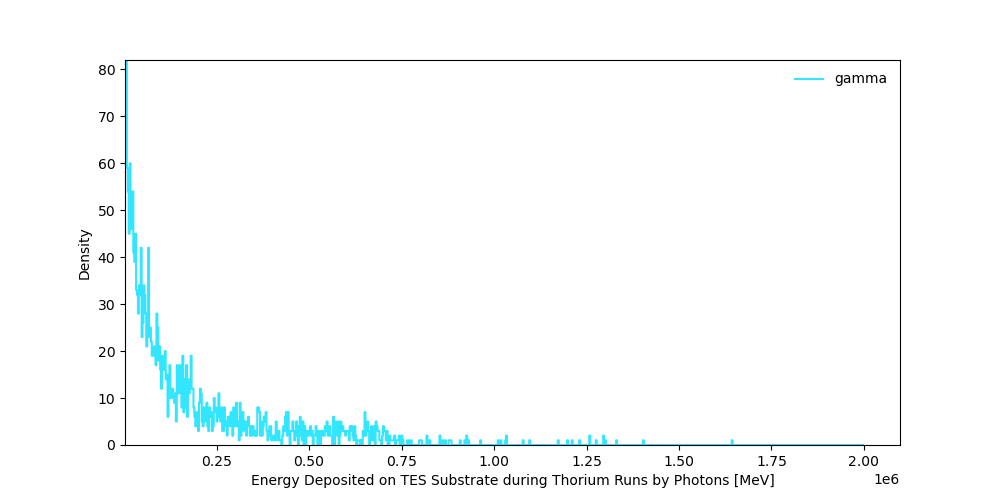

In [122]:
# Plot a histogram
fig = plt.figure(figsize=(10,5))
ax  = fig.add_subplot(111)

NBINS       = 800
LIMS        = (0,2)
BINS        = np.linspace(*LIMS,NBINS+1)
PARTICLE    = 'gamma'
stackedHist = np.histogram(gammaWithSecondaries.EnergyDeposited,bins=BINS)[0]
color       = np.round(np.random.rand(len(stackedHist),3),1)
ax.step(BINS[:-1]*1e6,stackedHist,label=PARTICLE,color=color[0])

ax.set_xlim(BINS[1]*1e6,None)
ax.set_ylim(0,np.max(stackedHist[1:]))
ax.set_xlabel('Energy Deposited on TES Substrate during Thorium Runs by Photons [MeV]')
ax.set_ylabel('Density')
ax.legend(frameon=False)
# ax.set_yscale('log')
# ax.set_xscale('log')

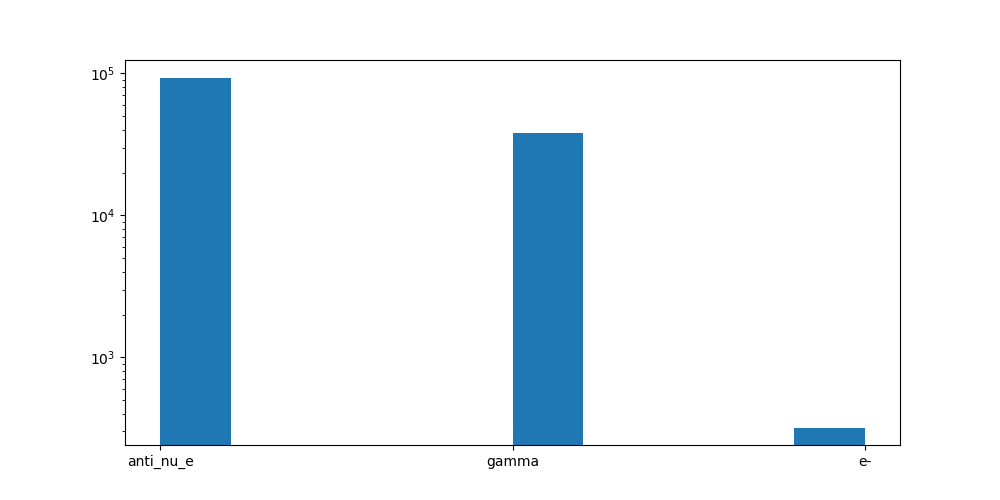

In [105]:
plt.clf()
plt.hist(data[data['MigrantID'] < 0]['Particle'])
plt.yscale('log')
plt.show()

In [108]:
gammaWithSecondaries = gammaWithSecondaries[gammaWithSecondaries['EnergyDeposited'] > 0.0]
gammaWithSecondaries

,EventID,TrackID,EnergyDeposited
0,495,26,0.041718
1,502,25,0.267561
2,1462,20,0.189352
3,2496,14,0.068181
4,2559,17,0.137506
...,...,...,...
2763,973677,16,0.042596
2764,974187,17,0.075253
2765,974641,38,0.090330
2766,975228,17,0.015156


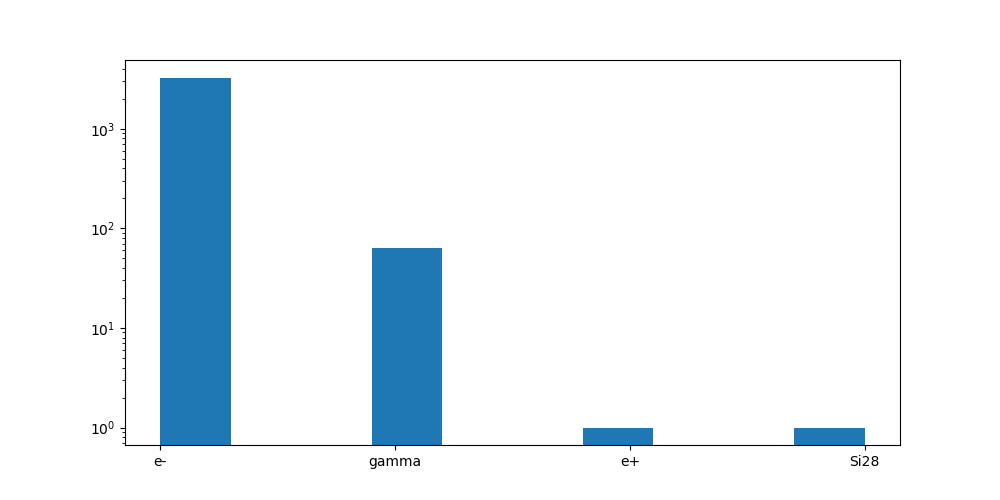

In [127]:
plt.clf()
plt.hist(data[data['MigrantID']>0]['Particle'])
plt.yscale('log')
plt.show()

In [128]:
data

,EventID,TrackID,Particle,Origin Volume,MigrantID,EnergyDeposited
0,0,14,anti_nu_e,physicalThorium,-1,0.0
1,12,34,anti_nu_e,physicalThorium,-1,0.0
2,35,17,gamma,physicalThorium,-1,0.0
3,41,30,anti_nu_e,physicalThorium,-1,0.0
4,51,39,anti_nu_e,physicalThorium,-1,0.0
...,...,...,...,...,...,...
135130,976525,20,gamma,physicalThorium,-1,0.0
135131,976529,36,anti_nu_e,physicalThorium,-1,0.0
135132,976532,34,gamma,physicalThorium,-1,0.0
135133,976555,35,anti_nu_e,physicalThorium,-1,0.0


In [136]:
originInside = data[data['MigrantID'] != -1]
originInside = originInside.drop(columns = ['TrackID', 'Particle','Origin Volume'])
originInside = originInside.rename(columns = {'MigrantID':'TrackID', 'EnergyDeposited':'EnergyFromInside'})
originInside

,EventID,TrackID,EnergyFromInside
58,495,26,0.041566
60,502,25,0.265733
61,502,27,0.001566
179,1462,20,0.189338
329,2496,14,0.068175
...,...,...,...
134738,973677,16,0.042444
134813,974187,17,0.075247
134882,974641,38,0.088486
134987,975228,17,0.015149


In [137]:
originOutside = data[data['MigrantID'] == -1]
originOutside = originOutside.drop(columns = ['Origin Volume','MigrantID'])
originOutside = originOutside.rename(columns = {'EnergyDeposited':'EnergyFromOutside'})
originOutside

,EventID,TrackID,Particle,EnergyFromOutside
0,0,14,anti_nu_e,0.0
1,12,34,anti_nu_e,0.0
2,35,17,gamma,0.0
3,41,30,anti_nu_e,0.0
4,51,39,anti_nu_e,0.0
...,...,...,...,...
135130,976525,20,gamma,0.0
135131,976529,36,anti_nu_e,0.0
135132,976532,34,gamma,0.0
135133,976555,35,anti_nu_e,0.0


In [145]:
combined = pd.merge(originOutside, originInside, on = ['EventID', 'TrackID'], how = 'left').fillna(0)
combined['EnergyDeposited'] = combined['EnergyFromOutside'] + combined['EnergyFromInside']
combined = combined[combined['EnergyDeposited'] > 0.0]
combined

,EventID,TrackID,Particle,EnergyFromOutside,EnergyFromInside,EnergyDeposited
57,495,26,gamma,0.000152,0.041566,0.041718
58,502,25,gamma,0.001829,0.265733,0.267561
175,1462,20,gamma,0.000014,0.189338,0.189352
324,2496,14,gamma,0.000007,0.068175,0.068181
335,2559,17,gamma,0.000007,0.137500,0.137506
...,...,...,...,...,...,...
131734,974212,34,e-,0.070647,0.000000,0.070647
131796,974641,38,gamma,0.001844,0.088486,0.090330
131900,975228,17,gamma,0.000007,0.015149,0.015156
131953,975681,15,e-,0.053221,0.000000,0.053221


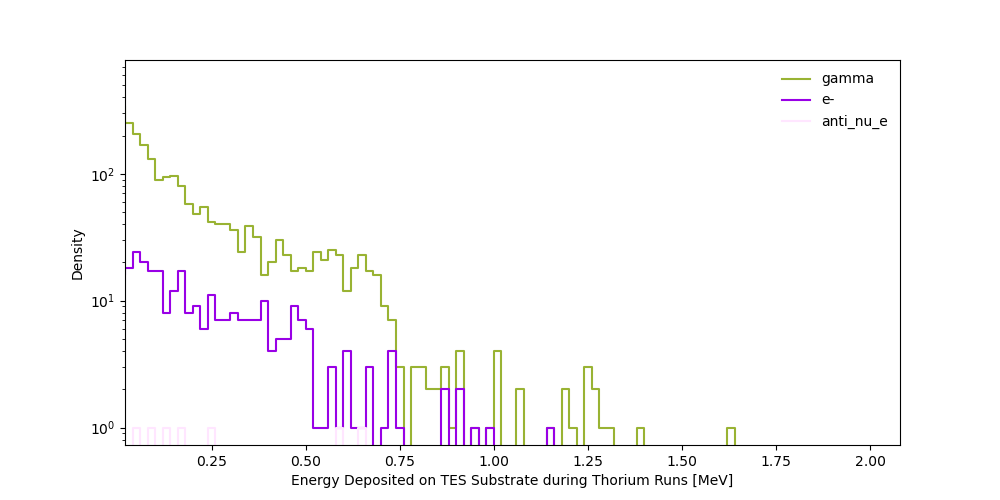

In [147]:
particleEnergies = {particle:combined.loc[combined.Particle == particle] for particle in combined.Particle.unique()}
# Plot a histogram
fig = plt.figure(figsize=(10,5))
ax  = fig.add_subplot(111)

NBINS       = 100
LIMS        = (0,2)
BINS        = np.linspace(*LIMS,NBINS+1)
stackedHist = np.array([np.histogram(particleEnergies[particle].EnergyDeposited,bins=BINS)[0] for particle in particleEnergies])
color       = np.round(np.random.rand(len(stackedHist),3),1)
[ax.step(BINS[:-1],hist,label=particle,color=c) for hist,particle,c in zip(stackedHist,particleEnergies,color)]

ax.set_xlim(BINS[1],None)
# ax.set_ylim(0,np.max(,axis=0))
ax.set_xlabel('Energy Deposited on TES Substrate during Thorium Runs [MeV]')
ax.set_ylabel('Density')
ax.legend(frameon=False)
ax.set_yscale('log')
# ax.set_xscale('log')